In [3]:
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For visualization
import seaborn as sns  # For advanced visualization
from sklearn.model_selection import train_test_split  # For splitting datasets
from sklearn.ensemble import RandomForestClassifier  # Example ML model
from sklearn.metrics import accuracy_score, classification_report  # For evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


In [4]:
# Load the dataset
data = pd.read_csv("C:\C964\DNA_mutation_dataset\combined_dataset_with_recalculated_q_values.csv")

#Display the first few rows
data.head()

,gene,mutation,count,mutability,B_Score,label,p_value,q_value
0,BRAF,F595L,1,9.310000e-07,6.510000e-05,Non-neutral,9.310000e-07,6.579840e-04
1,BRAF,L597Q,2,4.400000e-07,2.640000e-08,Non-neutral,9.680000e-14,4.460000e-07
2,BRAF,L597R,0,2.030000e-07,2.493301e-03,Non-neutral,1.000000e+00,1.594271e-02
3,BRAF,V600E,549,3.120000e-07,0.000000e+00,Non-neutral,0.000000e+00,0.000000e+00
4,BRAF,G464V,1,1.090000e-06,8.950000e-05,Non-neutral,1.090000e-06,8.809740e-04


In [5]:
# Define features and target for the neutral/non-neutral classification
X_model1 = data[['gene', 'mutation', 'mutability', 'count']]  # Add other features if necessary
y_model1 = (data['label'] == 'Non-neutral').astype(int)  # Binary target: 1 for non-neutral, 0 for neutral

# One-hot encode categorical variables
X_model1 = pd.get_dummies(X_model1, columns=['gene', 'mutation'])

# Split the data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_model1, y_model1, test_size=0.2, random_state=42)

# Check shapes
X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape


((4220, 5277), (1056, 5277), (4220,), (1056,))

In [6]:
# Initialize and train the Random Forest Classifier
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model1.fit(X_train1, y_train1)

# Evaluate feature importance
importances = pd.Series(model1.feature_importances_, index=X_train1.columns)
importances.sort_values(ascending=False).head(10)


count          0.143415
gene_POLE      0.052661
gene_TP53      0.044035
mutability     0.035897
gene_POLD1     0.031601
gene_PIK3CA    0.026876
gene_EGFR      0.021200
gene_KIT       0.013636
gene_BRAF      0.013102
gene_KRAS      0.009477
dtype: float64

In [7]:
# Make predictions
y_pred1 = model1.predict(X_test1)

# Evaluate the model
print("Classification Report for Neutral/Non-Neutral Classification:")
print(classification_report(y_test1, y_pred1))
print("Confusion Matrix:")
print(confusion_matrix(y_test1, y_pred1))
print("ROC AUC Score:", roc_auc_score(y_test1, model1.predict_proba(X_test1)[:, 1]))



Classification Report for Neutral/Non-Neutral Classification:
              precision    recall  f1-score   support

           0       0.88      0.98      0.92       819
           1       0.86      0.54      0.66       237

    accuracy                           0.88      1056
   macro avg       0.87      0.76      0.79      1056
weighted avg       0.88      0.88      0.87      1056

Confusion Matrix:
[[799  20]
 [110 127]]
ROC AUC Score: 0.9214746809683518


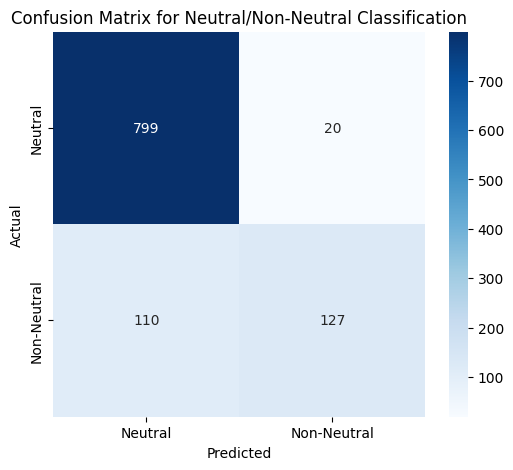

In [8]:
# Generate the confusion matrix
cm = confusion_matrix(y_test1, y_pred1)

# Visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neutral", "Non-Neutral"],
            yticklabels=["Neutral", "Non-Neutral"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Neutral/Non-Neutral Classification")
plt.show()

In [9]:

import joblib

# Save the trained model
joblib.dump(model1, "neutral_nonneutral_classification_model.pkl")


['neutral_nonneutral_classification_model.pkl']

In [10]:
# Filter non-neutral mutations based on Model 1 predictions or dataset label
data_non_neutral = data[data['label'] == 'Non-neutral']

# Define features and target for the driver prediction model
X_model2 = data_non_neutral[['mutability', 'count', 'B_Score']]  # Add more features if necessary
y_model2 = (data_non_neutral['q_value'] < 0.05).astype(int)  # 1 for driver, 0 for non-driver

# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_model2, y_model2, test_size=0.2, random_state=42)

# Check shapes
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape


((911, 3), (228, 3), (911,), (228,))

Feature Importances:
B_Score       0.501640
mutability    0.368269
count         0.130090
dtype: float64


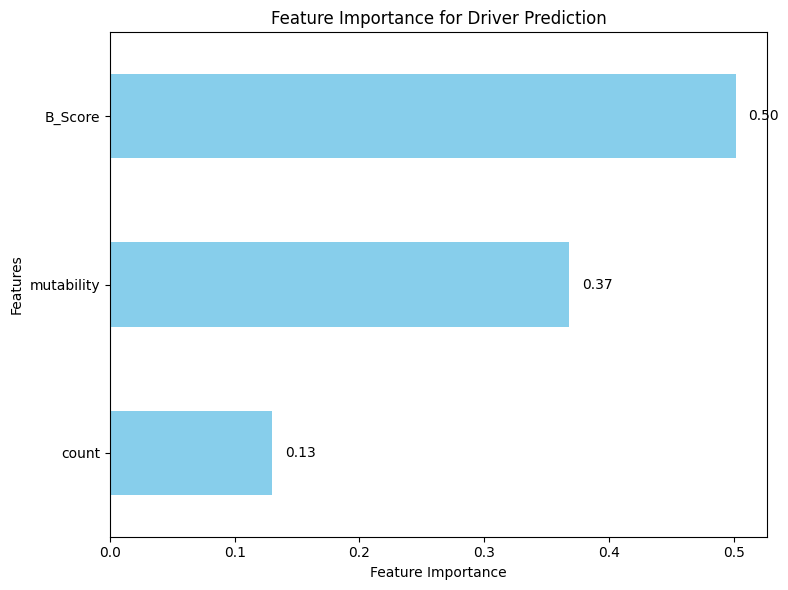

In [11]:
# Initialize and train the Random Forest Classifier
model2 = RandomForestClassifier(n_estimators=100, random_state=42)
model2.fit(X_train2, y_train2)

# Evaluate feature importance
importances = pd.Series(model2.feature_importances_, index=X_train2.columns)
print("Feature Importances:")
print(importances.sort_values(ascending=False))

# Plot feature importance with values
plt.figure(figsize=(8, 6))
ax = importances.sort_values(ascending=True).plot(kind='barh', color='skyblue')
for i, v in enumerate(importances.sort_values(ascending=True)):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')  # Add text next to bars

plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Driver Prediction")
plt.tight_layout()
plt.show()


In [12]:
# Make predictions
y_pred2 = model2.predict(X_test2)

# Evaluate the model
print("Classification Report for Driver/Non-Driver Prediction:")
print(classification_report(y_test2, y_pred2))
print("Confusion Matrix:")
print(confusion_matrix(y_test2, y_pred2))
print("ROC AUC Score:", roc_auc_score(y_test2, model2.predict_proba(X_test2)[:, 1]))


Classification Report for Driver/Non-Driver Prediction:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00       210

    accuracy                           1.00       228
   macro avg       1.00      1.00      1.00       228
weighted avg       1.00      1.00      1.00       228

Confusion Matrix:
[[ 18   0]
 [  0 210]]
ROC AUC Score: 1.0


In [13]:
import joblib

# Save the trained model
joblib.dump(model2, "driver_prediction_model.pkl")


['driver_prediction_model.pkl']

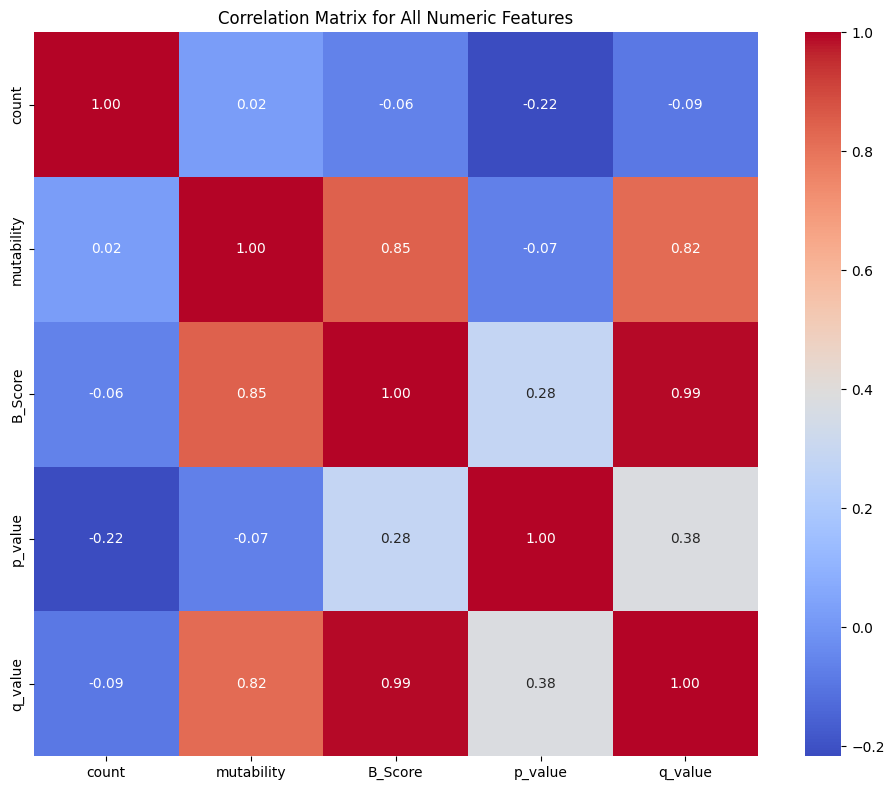

In [14]:
# Load your dataset
data = pd.read_csv("C:\C964\DNA_mutation_dataset\combined_dataset_with_recalculated_q_values.csv")

# Exclude non-numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation = numeric_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix for All Numeric Features")
plt.tight_layout()
plt.show()